## Import Required Libraries

In [17]:
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import warnings
warnings.filterwarnings('ignore')

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")


Using device: cuda
PyTorch version: 2.9.0+cu126


## Load Preprocessed Text Data

In [18]:
# Load the preprocessed text embeddings file
print("Loading preprocessed text data...")

text_data = pd.read_csv('preprocessed_text_embeddings.csv')

print(f"✓ Data loaded successfully!")
print(f"  Shape: {text_data.shape}")
print(f"  Columns: {list(text_data.columns)}")
print(f"\nFirst few rows:")
print(text_data.head())


Loading preprocessed text data...
✓ Data loaded successfully!
  Shape: (53220, 11)
  Columns: ['ID', 'address', 'des_head', 'des_content', 'features', 'Formated_Address', 'Locality', 'State', 'Postal Code', 'agency_name', 'combined_text']

First few rows:
          ID                                    address  \
0    7513227          544 Velore Road Denison Vic 3858    
1    7720571        1375 Ballan Road Quandong Vic 3030    
2  104997043    1/76 Scotsburn Avenue Clayton Vic 3168    
3  105023594          47 Lee Street Deer Park Vic 3023    
4  105140240  15 Fiddian Court Altona Meadows Vic 3028    

                                            des_head  \
0                                   Farmlet Makeover   
1          Lifestyle 100 Acres Conservation Property   
2                       Exceptional Modern Elegance!   
3  Spacious single level family home located minu...   
4                                EASY CARE LIFESTYLE   

                                         des_content

## Explore Text Data

In [19]:
# Explore the text data
print("\n" + "="*80)
print("TEXT DATA EXPLORATION")
print("="*80)

print(f"\nTotal properties: {len(text_data)}")
print(f"\nMissing values:")
print(text_data.isnull().sum())

# Check text lengths
print(f"\nText Length Statistics:")
text_data['combined_text_length'] = text_data['combined_text'].str.len()
print(f"  Combined text - Mean length: {text_data['combined_text_length'].mean():.0f} chars")
print(f"  Combined text - Max length: {text_data['combined_text_length'].max()} chars")
print(f"  Combined text - Min length: {text_data['combined_text_length'].min()} chars")

# Check for empty texts
empty_texts = text_data['combined_text'].str.strip().str.len() == 0
print(f"\n  Properties with empty combined text: {empty_texts.sum()}")

print("\n" + "="*80)



TEXT DATA EXPLORATION

Total properties: 53220

Missing values:
ID                    0
address               0
des_head              0
des_content           0
features              0
Formated_Address    302
Locality            302
State               302
Postal Code         302
agency_name           0
combined_text         0
dtype: int64

Text Length Statistics:
  Combined text - Mean length: 1024 chars
  Combined text - Max length: 3674 chars
  Combined text - Min length: 107 chars

  Properties with empty combined text: 0



## Clean and Prepare Text Data

In [20]:
# Clean text data
print("Cleaning text data...")

# Fill any remaining NaN values
text_data['combined_text'] = text_data['combined_text'].fillna('')
text_data['des_head'] = text_data['des_head'].fillna('')
text_data['des_content'] = text_data['des_content'].fillna('')
text_data['features'] = text_data['features'].fillna('')

# Clean text: remove extra whitespace, newlines, etc.
def clean_text(text):
    if pd.isna(text) or text == '':
        return ''
    # Remove extra whitespace
    text = ' '.join(text.split())
    # Remove special characters but keep basic punctuation
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    return text.strip()

text_data['combined_text_clean'] = text_data['combined_text'].apply(clean_text)
text_data['des_head_clean'] = text_data['des_head'].apply(clean_text)
text_data['des_content_clean'] = text_data['des_content'].apply(clean_text)
text_data['features_clean'] = text_data['features'].apply(clean_text)

print("✓ Text data cleaned!")

# Show sample
print("\nSample cleaned text:")
print(text_data['combined_text_clean'].iloc[0][:300], "...")

Cleaning text data...
✓ Text data cleaned!

Sample cleaned text:
Farmlet Makeover Established farmlet that has had a major makeover with new kitchen, bathroom, en-suite and family room. Located only 16Kms from Sale a peaceful rural location is this established property. The home has recently been rendered, re-wired, re plumbed and enclosed the garage into a great ...


## Initialize Sentence Transformer Model

In [21]:
# Load pre-trained Sentence-BERT model
print("Loading Sentence-BERT model...")

# Use 'all-MiniLM-L6-v2' - fast and efficient model (384 dimensions)
# Alternative options:
# - 'all-mpnet-base-v2' (768 dimensions, higher quality but slower)
# - 'all-MiniLM-L12-v2' (384 dimensions, balanced)
# - 'paraphrase-MiniLM-L6-v2' (384 dimensions, good for semantic similarity)

model_name = 'all-mpnet-base-v2'
model = SentenceTransformer(model_name, device=device)

print(f"✓ Model loaded: {model_name}")
print(f"  Embedding dimension: {model.get_sentence_embedding_dimension()}")
print(f"  Max sequence length: {model.max_seq_length}")


Loading Sentence-BERT model...
✓ Model loaded: all-mpnet-base-v2
  Embedding dimension: 768
  Max sequence length: 384


In [23]:
# Check if any texts exceed the model's max sequence length
print("Checking text lengths...")

# Tokenize to count tokens (approximate)
def count_tokens(text):
    return len(text.split())

text_data['token_count'] = text_data['combined_text_clean'].apply(count_tokens)

print(f"\Word count statistics:")
print(f"  Mean: {text_data['token_count'].mean():.0f}")
print(f"  Max: {text_data['token_count'].max()}")
print(f"  Properties exceeding 384 tokens: {(text_data['token_count'] > 294).sum()}") #384 tokens approximately equals to 294(294*1.3=384)

# Truncate very long texts if needed
def truncate_text(text, max_words=294):
    words = text.split()
    if len(words) > max_words:
        return ' '.join(words[:max_words])
    return text

text_data['combined_text_final'] = text_data['combined_text_clean'].apply(
    lambda x: truncate_text(x, max_words=294)
)

print("\n✓ Long texts handled!")


Checking text lengths...
\Word count statistics:
  Mean: 149
  Max: 530
  Properties exceeding 384 tokens: 1

✓ Long texts handled!


## Generate Embeddings for Combined Text

In [28]:
# Generate embeddings for combined text
print("\nGenerating embeddings for combined text...")

# Convert to list
combined_texts = text_data['combined_text_final'].tolist()

# Generate embeddings in batches for efficiency
batch_size = 512
combined_embeddings = model.encode(
    combined_texts,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True  # Normalize to unit length for cosine similarity
)

print(f"\n✓ Combined text embeddings generated!")
print(f"  Shape: {combined_embeddings.shape}")
print(f"  Embedding dimension: {combined_embeddings.shape[1]}")



Generating embeddings for combined text...


Batches:   0%|          | 0/104 [00:00<?, ?it/s]


✓ Combined text embeddings generated!
  Shape: (53220, 768)
  Embedding dimension: 768


## Generate Embeddings for Description Headline

In [29]:
# Generate embeddings for description headlines
print("\nGenerating embeddings for description headlines...")

des_head_texts = text_data['des_head_clean'].tolist()

des_head_embeddings = model.encode(
    des_head_texts,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

print(f"✓ Description headline embeddings generated!")
print(f"  Shape: {des_head_embeddings.shape}")



Generating embeddings for description headlines...


Batches:   0%|          | 0/104 [00:00<?, ?it/s]

✓ Description headline embeddings generated!
  Shape: (53220, 768)


## Generate Embeddings for Description Content

In [30]:
# Generate embeddings for description content
print("\nGenerating embeddings for description content...")

des_content_texts = text_data['des_content_clean'].tolist()

# Truncate very long content
des_content_texts_truncated = [truncate_text(text, max_words=400) for text in des_content_texts]

des_content_embeddings = model.encode(
    des_content_texts_truncated,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

print(f"✓ Description content embeddings generated!")
print(f"  Shape: {des_content_embeddings.shape}")



Generating embeddings for description content...


Batches:   0%|          | 0/104 [00:00<?, ?it/s]

✓ Description content embeddings generated!
  Shape: (53220, 768)


## Generate Embeddings for Features

In [31]:
# Generate embeddings for property features
print("\nGenerating embeddings for property features...")

features_texts = text_data['features_clean'].tolist()

features_embeddings = model.encode(
    features_texts,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

print(f"✓ Features embeddings generated!")
print(f"  Shape: {features_embeddings.shape}")



Generating embeddings for property features...


Batches:   0%|          | 0/104 [00:00<?, ?it/s]

✓ Features embeddings generated!
  Shape: (53220, 768)


## Combine All Text Embeddings

In [32]:
# Combine different text embeddings
print("\nCombining text embeddings...")

# Option 1: Concatenate all embeddings
all_text_embeddings = np.concatenate([
    combined_embeddings,
    des_head_embeddings,
    des_content_embeddings,
    features_embeddings
], axis=1)

print(f"✓ All text embeddings combined (concatenation)!")
print(f"  Final shape: {all_text_embeddings.shape}")
print(f"  Total embedding dimension: {all_text_embeddings.shape[1]}")

# Option 2: Weighted average (alternative approach)
weights = [0.4, 0.2, 0.3, 0.1]  # Weights for combined, head, content, features
weighted_embeddings = (
    weights[0] * combined_embeddings +
    weights[1] * des_head_embeddings +
    weights[2] * des_content_embeddings +
    weights[3] * features_embeddings
)

print(f"\n✓ Weighted average embeddings created!")
print(f"  Shape: {weighted_embeddings.shape}")



Combining text embeddings...
✓ All text embeddings combined (concatenation)!
  Final shape: (53220, 3072)
  Total embedding dimension: 3072

✓ Weighted average embeddings created!
  Shape: (53220, 768)


## Create Embeddings DataFrame (Concatenated)

In [33]:
# Create DataFrame with concatenated embeddings
print("\nCreating text embeddings DataFrame (concatenated version)...")

# Create column names
embedding_dim = combined_embeddings.shape[1]
column_names = []
column_names += [f'text_combined_{i}' for i in range(embedding_dim)]
column_names += [f'text_head_{i}' for i in range(embedding_dim)]
column_names += [f'text_content_{i}' for i in range(embedding_dim)]
column_names += [f'text_features_{i}' for i in range(embedding_dim)]

# Create DataFrame
text_embeddings_concat_df = pd.DataFrame(
    all_text_embeddings,
    columns=column_names
)

# Add property ID
text_embeddings_concat_df.insert(0, 'ID', text_data['ID'].values)

print(f"✓ Concatenated embeddings DataFrame created!")
print(f"  Shape: {text_embeddings_concat_df.shape}")
print(f"  Total embedding features: {all_text_embeddings.shape[1]}")



Creating text embeddings DataFrame (concatenated version)...
✓ Concatenated embeddings DataFrame created!
  Shape: (53220, 3073)
  Total embedding features: 3072


## Create Embeddings DataFrame (Weighted Average)

In [34]:
# Create DataFrame with weighted average embeddings
print("\nCreating text embeddings DataFrame (weighted average version)...")

# Create column names
column_names_weighted = [f'text_emb_{i}' for i in range(weighted_embeddings.shape[1])]

# Create DataFrame
text_embeddings_weighted_df = pd.DataFrame(
    weighted_embeddings,
    columns=column_names_weighted
)

# Add property ID
text_embeddings_weighted_df.insert(0, 'ID', text_data['ID'].values)

print(f"✓ Weighted average embeddings DataFrame created!")
print(f"  Shape: {text_embeddings_weighted_df.shape}")
print(f"  Embedding dimension: {weighted_embeddings.shape[1]}")



Creating text embeddings DataFrame (weighted average version)...
✓ Weighted average embeddings DataFrame created!
  Shape: (53220, 769)
  Embedding dimension: 768


## Create Enhanced Combined Embeddings

In [35]:
# Create enhanced embeddings: use only combined text but with better preprocessing
print("\nCreating enhanced combined text embeddings...")

# For final use, we'll use the combined text embeddings as they already include all info
enhanced_embeddings = combined_embeddings.copy()

# Create DataFrame
column_names_enhanced = [f'text_emb_{i}' for i in range(enhanced_embeddings.shape[1])]

text_embeddings_final_df = pd.DataFrame(
    enhanced_embeddings,
    columns=column_names_enhanced
)

# Add property ID
text_embeddings_final_df.insert(0, 'ID', text_data['ID'].values)

print(f"✓ Enhanced text embeddings DataFrame created!")
print(f"  Shape: {text_embeddings_final_df.shape}")
print(f"  This is the recommended version for model training!")



Creating enhanced combined text embeddings...
✓ Enhanced text embeddings DataFrame created!
  Shape: (53220, 769)
  This is the recommended version for model training!


## Visualize Text Embeddings


Visualizing text embeddings...


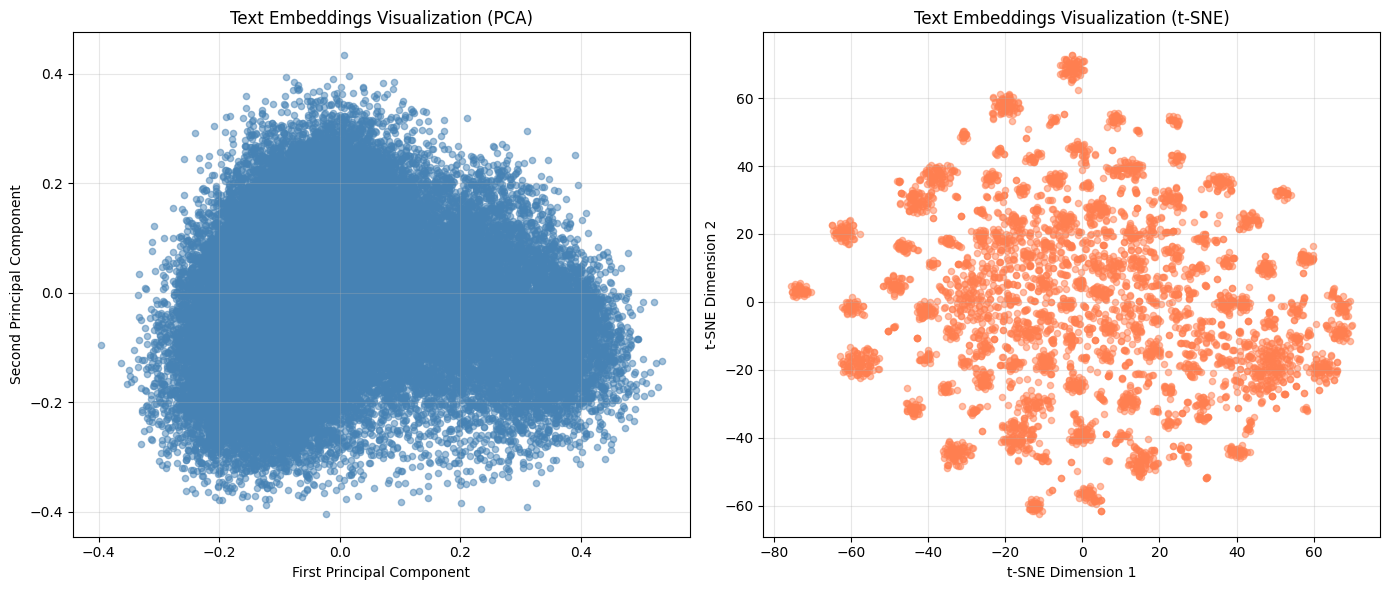

✓ Visualization saved as 'text_embeddings_visualization.png'
  PCA explained variance: 12.26%


In [36]:
# Visualize embeddings using dimensionality reduction
print("\nVisualizing text embeddings...")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply PCA for visualization
pca = PCA(n_components=2)
embeddings_2d_pca = pca.fit_transform(enhanced_embeddings)

# Plot PCA
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(embeddings_2d_pca[:, 0], embeddings_2d_pca[:, 1],
           alpha=0.5, s=20, c='steelblue')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Text Embeddings Visualization (PCA)')
plt.grid(True, alpha=0.3)

# Apply t-SNE for visualization (on a sample if dataset is large)
if len(enhanced_embeddings) > 5000:
    sample_indices = np.random.choice(len(enhanced_embeddings), 5000, replace=False)
    sample_embeddings = enhanced_embeddings[sample_indices]
else:
    sample_embeddings = enhanced_embeddings

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d_tsne = tsne.fit_transform(sample_embeddings)

plt.subplot(1, 2, 2)
plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1],
           alpha=0.5, s=20, c='coral')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Text Embeddings Visualization (t-SNE)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('text_embeddings_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Visualization saved as 'text_embeddings_visualization.png'")
print(f"  PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")


## Calculate Embedding Statistics

In [37]:
# Calculate embedding statistics
print("\n" + "="*80)
print("TEXT EMBEDDINGS STATISTICS")
print("="*80)

print(f"\nEmbedding Dimensions:")
print(f"  Total properties embedded: {len(text_embeddings_final_df)}")
print(f"  Embedding vector size: {enhanced_embeddings.shape[1]}")
print(f"  Total text features: {enhanced_embeddings.shape[0] * enhanced_embeddings.shape[1]:,}")

print(f"\nEmbedding Distribution:")
print(f"  Mean: {enhanced_embeddings.mean():.4f}")
print(f"  Std: {enhanced_embeddings.std():.4f}")
print(f"  Min: {enhanced_embeddings.min():.4f}")
print(f"  Max: {enhanced_embeddings.max():.4f}")

# Check for any zero embeddings
zero_embeddings = np.all(enhanced_embeddings == 0, axis=1)
print(f"\n  Properties with zero embeddings: {zero_embeddings.sum()}")

print(f"\nText Processing Summary:")
print(f"  Model used: {model_name}")
print(f"  Embedding dimension: {model.get_sentence_embedding_dimension()}")
print(f"  Normalization: Yes (L2 normalized)")
print(f"  Max sequence length: {model.max_seq_length} tokens")



TEXT EMBEDDINGS STATISTICS

Embedding Dimensions:
  Total properties embedded: 53220
  Embedding vector size: 768
  Total text features: 40,872,960

Embedding Distribution:
  Mean: -0.0002
  Std: 0.0361
  Min: -0.2298
  Max: 0.2152

  Properties with zero embeddings: 0

Text Processing Summary:
  Model used: all-mpnet-base-v2
  Embedding dimension: 768
  Normalization: Yes (L2 normalized)
  Max sequence length: 384 tokens


## Compute Semantic Similarity Examples

In [39]:
# Show semantic similarity between properties
print("\nSemantic Similarity Analysis (Sample)...")

from sklearn.metrics.pairwise import cosine_similarity

# Select a few random properties
sample_indices = np.random.choice(len(text_data), min(5, len(text_data)), replace=False)

print("\nSample properties and their descriptions:")
for i, idx in enumerate(sample_indices):
    print(f"\nProperty {i+1} (ID: {text_data.iloc[idx]['ID']}):")
    print(f"  {text_data.iloc[idx]['combined_text_clean'][:150]}...")

# Compute similarity matrix for sample
sample_embeddings = enhanced_embeddings[sample_indices]
similarity_matrix = cosine_similarity(sample_embeddings)

print("\nCosine Similarity Matrix:")
print(np.round(similarity_matrix, 3))

print("\n✓ Similarity analysis complete!")



Semantic Similarity Analysis (Sample)...

Sample properties and their descriptions:

Property 1 (ID: 115497647):
  CLASSIC 1950s - A GREAT START! This delightful residence in an elevated cul de sac close to parks and CBD transport offers comfortable living now, wit...

Property 2 (ID: 115680567):
  Heritage Splendour This iconic and highly sought after building is one of Melbournes best example of heritage architecture and this studio apartment c...

Property 3 (ID: 118825647):
  Spacious North Facing Apartment With Entertainers Courtyard Inner city living at its finest amongst this architecturally designed complex surrounded b...

Property 4 (ID: 115030523):
  The Perfect Christmas Gift For Your Family! Set in a location delivering convenience at every turn with its outstanding access to shops, schools and t...

Property 5 (ID: 119141963):
  Sophisticated Living in Exclusive Location A private, tranquil sanctuary, magnificent in design and style, this stunning home delivers an impres

##  Save Text Embeddings

In [40]:
# Save all versions of text embeddings
print("\nSaving text embeddings...")

# Save main version (enhanced combined embeddings)
text_embeddings_final_df.to_csv('property_text_embeddings.csv', index=False)
print("✓ Saved 'property_text_embeddings.csv' (RECOMMENDED)")

# Save concatenated version (all text types combined)
text_embeddings_concat_df.to_csv('property_text_embeddings_concat.csv', index=False)
print("✓ Saved 'property_text_embeddings_concat.csv' (detailed version)")

# Save weighted version
text_embeddings_weighted_df.to_csv('property_text_embeddings_weighted.csv', index=False)
print("✓ Saved 'property_text_embeddings_weighted.csv' (weighted version)")

print("\nFile size comparison:")
import os
print(f"  Enhanced version: {os.path.getsize('property_text_embeddings.csv') / 1024 / 1024:.2f} MB")
print(f"  Concatenated version: {os.path.getsize('property_text_embeddings_concat.csv') / 1024 / 1024:.2f} MB")
print(f"  Weighted version: {os.path.getsize('property_text_embeddings_weighted.csv') / 1024 / 1024:.2f} MB")



Saving text embeddings...
✓ Saved 'property_text_embeddings.csv' (RECOMMENDED)
✓ Saved 'property_text_embeddings_concat.csv' (detailed version)
✓ Saved 'property_text_embeddings_weighted.csv' (weighted version)

File size comparison:
  Enhanced version: 483.64 MB
  Concatenated version: 1932.69 MB
  Weighted version: 486.40 MB


## Save Individual Embedding Components (Optional)

In [ ]:
# Save individual embedding components for flexibility
print("\nSaving individual embedding components...")

# Combined text embeddings
combined_emb_df = pd.DataFrame(combined_embeddings,
                               columns=[f'combined_{i}' for i in range(combined_embeddings.shape[1])])
combined_emb_df.insert(0, 'ID', text_data['ID'].values)
combined_emb_df.to_csv('text_embeddings_combined_only.csv', index=False)

# Description head embeddings
head_emb_df = pd.DataFrame(des_head_embeddings,
                          columns=[f'head_{i}' for i in range(des_head_embeddings.shape[1])])
head_emb_df.insert(0, 'ID', text_data['ID'].values)
head_emb_df.to_csv('text_embeddings_head_only.csv', index=False)

# Description content embeddings
content_emb_df = pd.DataFrame(des_content_embeddings,
                             columns=[f'content_{i}' for i in range(des_content_embeddings.shape[1])])
content_emb_df.insert(0, 'ID', text_data['ID'].values)
content_emb_df.to_csv('text_embeddings_content_only.csv', index=False)

# Features embeddings
features_emb_df = pd.DataFrame(features_embeddings,
                              columns=[f'features_{i}' for i in range(features_embeddings.shape[1])])
features_emb_df.insert(0, 'ID', text_data['ID'].values)
features_emb_df.to_csv('text_embeddings_features_only.csv', index=False)

print("✓ Individual component embeddings saved!")
print("  - text_embeddings_combined_only.csv")
print("  - text_embeddings_head_only.csv")
print("  - text_embeddings_content_only.csv")
print("  - text_embeddings_features_only.csv")


## Save Model and Preprocessing Info

In [41]:
# Save model information and preprocessing details
import json

preprocessing_info = {
    'model_name': model_name,
    'embedding_dimension': int(model.get_sentence_embedding_dimension()),
    'max_sequence_length': int(model.max_seq_length),
    'normalization': 'L2',
    'total_properties': int(len(text_data)),
    'text_fields_used': ['combined_text', 'des_head', 'des_content', 'features'],
    'truncation_max_words': 400,
    'batch_size': batch_size,
    'device': device
}

with open('text_embedding_info.json', 'w') as f:
    json.dump(preprocessing_info, f, indent=4)

print("✓ Model and preprocessing information saved!")
print("\nPreprocessing Info:")
print(json.dumps(preprocessing_info, indent=2))


✓ Model and preprocessing information saved!

Preprocessing Info:
{
  "model_name": "all-mpnet-base-v2",
  "embedding_dimension": 768,
  "max_sequence_length": 384,
  "normalization": "L2",
  "total_properties": 53220,
  "text_fields_used": [
    "combined_text",
    "des_head",
    "des_content",
    "features"
  ],
  "truncation_max_words": 400,
  "batch_size": 512,
  "device": "cuda"
}


## Create Summary Report

In [42]:
# Create comprehensive summary
print("\n" + "="*80)
print("TEXT EMBEDDINGS CREATION - SUMMARY REPORT")
print("="*80)

print(f"\nTEXT EMBEDDINGS SUCCESSFULLY GENERATED!")

print(f"\nDataset Overview:")
print(f"  Total properties processed: {len(text_data)}")
print(f"  Properties with non-empty text: {(text_data['combined_text_length'] > 0).sum()}")

print(f"\nModel Information:")
print(f"  Model: {model_name}")
print(f"  Embedding dimension: {model.get_sentence_embedding_dimension()}")
print(f"  Normalization: L2 (unit vectors)")

print(f"\nOutput Files Created:")
print(f"  ✓ property_text_embeddings.csv (MAIN FILE - use this)")
print(f"     Shape: {text_embeddings_final_df.shape}")
print(f"     Size: {os.path.getsize('property_text_embeddings.csv') / 1024 / 1024:.2f} MB")

print(f"\n  ✓ property_text_embeddings_concat.csv (alternative)")
print(f"     Shape: {text_embeddings_concat_df.shape}")

print(f"\n  ✓ property_text_embeddings_weighted.csv (alternative)")
print(f"     Shape: {text_embeddings_weighted_df.shape}")

print(f"\n  ✓ text_embeddings_*_only.csv (4 component files)")

print(f"\n  ✓ text_embeddings_visualization.png")
print(f"  ✓ text_embedding_info.json")

print(f"\nEmbedding Quality:")
print(f"  Mean embedding norm: {np.linalg.norm(enhanced_embeddings, axis=1).mean():.4f}")
print(f"  (Should be ~1.0 for normalized embeddings)")

print(f"\nNext Steps:")
print(f"  → Step 4: Create Image Embeddings from property photos")
print(f"  → Step 5: Combine graph, text, and image embeddings")
print(f"  → Step 6: Train final price prediction model")

print("\n" + "="*80)
print("TEXT EMBEDDING GENERATION COMPLETE!")
print("="*80)


TEXT EMBEDDINGS CREATION - SUMMARY REPORT

TEXT EMBEDDINGS SUCCESSFULLY GENERATED!

Dataset Overview:
  Total properties processed: 53220
  Properties with non-empty text: 53220

Model Information:
  Model: all-mpnet-base-v2
  Embedding dimension: 768
  Normalization: L2 (unit vectors)

Output Files Created:
  ✓ property_text_embeddings.csv (MAIN FILE - use this)
     Shape: (53220, 769)
     Size: 483.64 MB

  ✓ property_text_embeddings_concat.csv (alternative)
     Shape: (53220, 3073)

  ✓ property_text_embeddings_weighted.csv (alternative)
     Shape: (53220, 769)

  ✓ text_embeddings_*_only.csv (4 component files)

  ✓ text_embeddings_visualization.png
  ✓ text_embedding_info.json

Embedding Quality:
  Mean embedding norm: 1.0000
  (Should be ~1.0 for normalized embeddings)

Next Steps:
  → Step 4: Create Image Embeddings from property photos
  → Step 5: Combine graph, text, and image embeddings
  → Step 6: Train final price prediction model

TEXT EMBEDDING GENERATION COMPLETE!


## Summary
You've successfully created text embeddings using Sentence-BERT ! The process included:​

1. Loaded preprocessed text data from step 1

2. Cleaned and prepared text (removed extra whitespace, truncated long texts)

3. Generated embeddings using the all-MiniLM-L6-v2 model (384 dimensions)

4. Created multiple embedding versions:

- Combined text embeddings (recommended)

- Concatenated all text types

- Weighted average embeddings

- Individual component embeddings

5. Normalized embeddings for cosine similarity

6. Visualized embeddings using PCA and t-SNE

Main Output File:

- property_text_embeddings.csv - Contains property IDs and 384-dimensional text embeddings (USE THIS for Step 5)

Alternative Files:

- property_text_embeddings_concat.csv - All text types concatenated (1536 dimensions)

- property_text_embeddings_weighted.csv - Weighted average version

- Individual component files for flexibility

Next Step:

-
Step 4: Create image embeddings from property photos using CNN or Vision Transformers